In [1]:
import os
import re
import math
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster

from tqdm.auto import tqdm

import utils 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy.stats import norm

class FindTravelTime():


    def __init__(self,df) :
        self.df = df
        self.road_centroid = [  {"rd" : 1 , "start":(15.561914417289183, 100.12577439385959),"stop": (16.85901078855188, 99.12904080671557)},
                                {"rd" : 2 , "start":(14.850897312327184, 101.65609584505698),"stop": (16.27010669391355, 102.78036219710563)},
                                {"rd" : 4 , "start":(11.495837799354899, 99.59964040070624,),"stop": (13.314148102062967, 99.82484325754068)},
                                {"rd" : 7 , "start":(13.113253464736975, 100.95531837250864),"stop": (13.73277648540468, 100.76177909399911)},
                                {"rd" : 9 , "start":(13.649629122634497, 100.68650542608228,),"stop": (13.642726998935187,100.41451712861084)},
                                {"rd" : 32 ,"start":(14.198731291192727, 100.61185751693245),"stop": (15.275452778629077,100.19545773779554)},
                                {"rd" : 41 ,"start":(9.946246687710023, 99.06392436080117),"stop": (8.167021308334858, 99.66352696811437)},
                                {"rd" : 304 ,"start":(13.879089398416676,101.56885167383179),"stop":(14.388486307650279,101.86460689848363) },
                                {"rd" : 35 ,"start":(13.640325795495965, 100.40820722072358),"stop":(13.34104092128205, 99.83952892671479) },
                                {"rd" : 331 ,"start":(13.59731304067158, 101.29603419258949),"stop":(13.11827478284012, 101.02046471680859) }, ]
        


    def _init_minmaxlatlon(self,start_lat,start_lon,stop_lat,stop_lon) : 
        self.min_start_lat = start_lat - 0.01
        self.max_start_lat = start_lat + 0.01
        self.min_start_lon = start_lon - 0.01
        self.max_start_lon = start_lon + 0.01
        self.min_stop_lat = stop_lat - 0.01
        self.max_stop_lat = stop_lat + 0.01
        self.min_stop_lon = stop_lon - 0.01
        self.max_stop_lon = stop_lon + 0.01
    
    def set_road(self,num):  #insert index 0 - 9
        mapping = {"1": 0, "2":1 ,"4":2 , "7":3, "9":4, "32":5 , "41":6 , "304":7 ,"35":8, "331":9  }
        
        self._init_minmaxlatlon(self.road_centroid[mapping[str(num)]]["start"][0],self.road_centroid[mapping[str(num)]]
        ["start"][1],self.road_centroid[mapping[str(num)]]["stop"][0],self.road_centroid[mapping[str(num)]]["stop"][1])


    def _preprocess(self):
        start_lat_range = (self.min_start_lat <= self.df["lat"] ) & (self.df["lat"] <= self.max_start_lat)
        start_lon_range = (self.min_start_lon <= self.df["lon"] ) & (self.df["lon"] <= self.max_start_lon)

        stop_lat_range = (self.min_stop_lat <= self.df["lat"] ) & (self.df["lat"] <= self.max_stop_lat)
        stop_lon_range = (self.min_stop_lon <= self.df["lon"] ) & (self.df["lon"] <= self.max_stop_lon)

        df_start = self.df[start_lat_range & start_lon_range].reset_index(drop=True)
        df_stop = self.df[stop_lat_range & stop_lon_range].reset_index(drop=True)

    
        df_stop = df_stop[df_stop["unit_id"].isin(list(set(df_start["unit_id"])))].reset_index(drop=True) 
        df_stop["position"] = "stop"

        df_start = df_start[df_start["unit_id"].isin(list(set(df_stop["unit_id"])))].reset_index(drop=True)
        df_start["position"] = "start"

        df_tmp = df_start.append(df_stop).sort_values(by=["time_stamp"]).reset_index(drop=True)


        return df_tmp

    def find_travel_time(self):
        df = self._preprocess()
        list_uid = list(df["unit_id"].unique())
         
        start_stop = pd.DataFrame(columns=["unit_id","lat_0","lon_0","lat_1","lon_1","t0","t1","delta_t","speed"])
        stop_start = pd.DataFrame(columns=["unit_id","lat_0","lon_0","lat_1","lon_1","t0","t1","delta_t","speed"])

        for uid in list_uid :

            temp = df[df["unit_id"] == uid].reset_index(drop=True)
    
            for i in range(len(temp)-1):
                if (temp.loc[i,"position"] == "start") & (temp.loc[i+1,"position"]== "stop") :
                    start_stop = start_stop.append({"unit_id":temp.loc[i,"unit_id"],"lat_0":temp.loc[i,"lat"],
                    "lon_0":temp.loc[i,"lon"],"lat_1":temp.loc[i+1,"lat"],"lon_1":temp.loc[i+1,"lon"],"t0":temp.loc[i,"time_stamp"], 
                    "t1":temp.loc[i+1,"time_stamp"],"delta_t": pd.Timedelta(temp.loc[i+1,"time_stamp"] - temp.loc[i,"time_stamp"]).seconds},ignore_index=True)
                elif (temp.loc[i,"position"] == "stop") & (temp.loc[i+1,"position"]== "start") :
                    stop_start = stop_start.append({"unit_id":temp.loc[i,"unit_id"],"lat_0":temp.loc[i,"lat"],
                    "lon_0":temp.loc[i,"lon"],"lat_1":temp.loc[i+1,"lat"],"lon_1":temp.loc[i+1,"lon"],"t0":temp.loc[i,"time_stamp"],
                     "t1":temp.loc[i+1,"time_stamp"],"delta_t": pd.Timedelta(temp.loc[i+1,"time_stamp"] - temp.loc[i,"time_stamp"]).seconds},ignore_index=True)
        self.df_start_stop = start_stop
        self.df_stop_start = stop_start

        return start_stop ,stop_start

    def find_travel_time_select_hour(self,hour=1):
        df = self._preprocess()
        list_uid = list(df["unit_id"].unique())
         
        start_stop = pd.DataFrame(columns=["time_range","unit_id","lat_0","lon_0","lat_1","lon_1","delta_t"])
        stop_start = pd.DataFrame(columns=["time_range","unit_id","lat_0","lon_0","lat_1","lon_1","delta_t"])

        for uid in list_uid :

            temp = df[df["unit_id"] == uid].reset_index(drop=True)
    
            for i in range(len(temp)-1):
                if (temp.loc[i,"position"] == "start") & (temp.loc[i+1,"position"]== "stop") :
                    start_stop = start_stop.append({"unit_id":temp.loc[i,"unit_id"],"lat_0":temp.loc[i,"lat"],
                    "lon_0":temp.loc[i,"lon"],"lat_1":temp.loc[i+1,"lat"],"lon_1":temp.loc[i+1,"lon"],"time_range":(temp.loc[i,"time_stamp"].hour//hour)*hour, 
                    "delta_t": pd.Timedelta(temp.loc[i+1,"time_stamp"] - temp.loc[i,"time_stamp"]).seconds},ignore_index=True)
                elif (temp.loc[i,"position"] == "stop") & (temp.loc[i+1,"position"]== "start") :
                    stop_start = stop_start.append({"unit_id":temp.loc[i,"unit_id"],"lat_0":temp.loc[i,"lat"],
                    "lon_0":temp.loc[i,"lon"],"lat_1":temp.loc[i+1,"lat"],"lon_1":temp.loc[i+1,"lon"],"time_range":(temp.loc[i,"time_stamp"].hour//hour)*hour,
                    "delta_t": pd.Timedelta(temp.loc[i+1,"time_stamp"] - temp.loc[i,"time_stamp"]).seconds},ignore_index=True)

        start_stop = start_stop.sort_values(by=["time_range"]).reset_index(drop=True)
        stop_start = stop_start.sort_values(by=["time_range"]).reset_index(drop=True)

        start_stop = self._clean_outlier_entire_day(start_stop)
        stop_start = self._clean_outlier_entire_day(stop_start)

        start_stop = self._clean_outlier(start_stop)
        stop_start = self._clean_outlier(stop_start)

        self.df_start_stop = start_stop
        self.df_stop_start = stop_start

        return start_stop ,stop_start

    def plot_filter(self,df_road):

        plt.figure(figsize=(20,15))
        
        plt.scatter(x=df_road['lon'],y=df_road['lat'],s=0.5,alpha=0.5)

        df = self._preprocess()
        plt.scatter(x = df["lon"],y=df["lat"],c="red"  )

        plt.show

    def _clean_outlier(self,df):
        hour = list(set(df["time_range"]))
        all_clean = pd.DataFrame()

        for hr in hour :
            temp = df[df["time_range"] == hr]
            q1 = temp["delta_t"].quantile(0.25)
            q3 = temp["delta_t"].quantile(0.75)
            iqr = q3-q1  
            #print("hr = {} lower = {}  upper = {}".format(hr,(q1 - 1.5 * iqr),(q3 + 1.5 * iqr)))
            all_clean = all_clean.append(temp[(temp["delta_t"] >= (q1 - 1.5 * iqr))  & (temp["delta_t"] <= (q3 + 1.5 * iqr)) ])

        return all_clean

            
    def _clean_outlier_entire_day(self,df):
        q1 = df["delta_t"].quantile(0.25)
        q3 = df["delta_t"].quantile(0.75)
        iqr = q3-q1
        df = df[(df["delta_t"] >= (q1 - 1.5 * iqr))  & (df["delta_t"] <= (q3 + 1.5 * iqr)) ]

        return df

    def _find_speed(self,df):
        hours = list(set(df["time_range"]))
        li = []
        for hour in hours :
            time_at = df[df["timerange"] == hour]
            speed_sort = sorted(list(time_at["speed"]))

            speed_sort = [speed for speed in speed_sort if speed > 10]  #dop speed that lower than 10
            mean = statistics.mean(speed_sort)
            min_range = np.percentile(speed_sort,5)
            max_range = np.percentile(speed_sort,95)
            sd = statistics.stdev(speed_sort)

            speed_sort = [speed for speed in speed_sort if (speed >= min_range and speed <= max_range)]  #choose speed that in range 5 - 95 of percentile
            new_mean = statistics.mean(speed_sort)
            #print("Mean = {} percentile 5 = {} percentile 95 = {} new Mean {}".format(mean,min_range,max_range,new_mean) )
            #plt.figure(figsize=(10,5))
            #plt.title("Velocity at {} am when drop 0".format(hour))
            #plt.plot(x_1,norm.pdf(x_1,mean,sd))
            #plt.show()
            li.append(new_mean)
        return li

    def find_travel_time_with_speed_select_hour(self,hour=1,speed=True):
        df = self._preprocess()
        list_uid = list(df["unit_id"].unique())
         
        start_stop = pd.DataFrame(columns=["time_range","unit_id","lat_0","lon_0","lat_1","lon_1","delta_t","speed"])
        stop_start = pd.DataFrame(columns=["time_range","unit_id","lat_0","lon_0","lat_1","lon_1","delta_t","speed"])

        for uid in list_uid :

            temp = df[df["unit_id"] == uid].reset_index(drop=True)
    
            for i in range(len(temp)-1):
                if (temp.loc[i,"position"] == "start") & (temp.loc[i+1,"position"]== "stop") :
                    start_stop = start_stop.append({"unit_id":temp.loc[i,"unit_id"],"lat_0":temp.loc[i,"lat"],
                    "lon_0":temp.loc[i,"lon"],"lat_1":temp.loc[i+1,"lat"],"lon_1":temp.loc[i+1,"lon"],"time_range":(temp.loc[i,"time_stamp"].hour//hour)*hour, 
                    "delta_t": pd.Timedelta(temp.loc[i+1,"time_stamp"] - temp.loc[i,"time_stamp"]).seconds},ignore_index=True)

                elif (temp.loc[i,"position"] == "stop") & (temp.loc[i+1,"position"]== "start") :
                    stop_start = stop_start.append({"unit_id":temp.loc[i,"unit_id"],"lat_0":temp.loc[i,"lat"],
                    "lon_0":temp.loc[i,"lon"],"lat_1":temp.loc[i+1,"lat"],"lon_1":temp.loc[i+1,"lon"],"time_range":(temp.loc[i,"time_stamp"].hour//hour)*hour,
                    "delta_t": pd.Timedelta(temp.loc[i+1,"time_stamp"] - temp.loc[i,"time_stamp"]).seconds},ignore_index=True)

        start_stop = start_stop.sort_values(by=["time_range"]).reset_index(drop=True)
        stop_start = stop_start.sort_values(by=["time_range"]).reset_index(drop=True)

        start_stop = self._clean_outlier_entire_day(start_stop)
        stop_start = self._clean_outlier_entire_day(stop_start)

        start_stop = self._clean_outlier(start_stop)
        stop_start = self._clean_outlier(stop_start)

        if speed :
            start_stop["speed"] = _find_speed(df)

        self.df_start_stop = start_stop
        self.df_stop_start = stop_start

        return start_stop ,stop_start



        
    

In [2]:
gps_data_dir = 'E:'
year_list = ["2019"]
months_list = ["03"]
days_list = ["01"]

df = utils.load_gps_data(gps_data_dir,days_list,months_list,year_list)

In [68]:
df

,time_stamp,unit_id,lat,lon,speed,unit_type
0,2019-03-01 00:00:32,0390002000000000000EE107549,19.950153,99.236827,3,8.0
1,2019-03-01 00:00:28,005000600000864507030191018,14.076360,100.520670,0,8.0
2,2019-03-01 00:00:39,003000900000000011872900652,17.526147,100.260691,34,8.0
3,2019-03-01 00:00:37,025000600000359857080414386,15.897020,101.920580,0,8.0
4,2019-03-01 00:00:32,025000600000359857080410830,16.131700,102.228890,0,8.0
...,...,...,...,...,...,...
15057226,2019-03-01 23:59:59,0190002000000000001228111200,13.631940,100.708328,53,8.0
15057227,2019-03-01 23:59:59,0190002000000000001228111200,13.631940,100.708328,53,8.0
15057228,2019-03-01 23:59:59,002000300000000000000508238,14.326200,102.753733,0,8.0
15057229,2019-03-01 23:59:00,025000200000863835024114360,16.703716,103.065875,0,8.0


In [64]:
fv = FindTravelTime(df)

In [65]:
fv.set_road("1")

In [66]:
tmp = fv._preprocess()

In [67]:
tmp

,time_stamp,unit_id,lat,lon,speed,unit_type,position
0,2019-03-01 00:17:51,013000200000861311007622201,16.859468,99.130903,0,5.0,stop
1,2019-03-01 00:32:41,0030007000003K00404PAJ222C5,15.567783,100.126064,51,8.0,start
2,2019-03-01 00:42:14,013000200000861311007622201,16.859468,99.130903,0,5.0,stop
3,2019-03-01 00:42:14,013000200000861311007622201,16.859468,99.130903,0,5.0,stop
4,2019-03-01 00:46:16,013000200000861311007622201,16.859468,99.130903,0,5.0,stop
...,...,...,...,...,...,...,...
228,2019-03-01 23:24:21,005000800000864507032183989,16.859610,99.130360,72,8.0,stop
229,2019-03-01 23:25:21,005000800000864507032183989,16.863980,99.137870,32,8.0,stop
230,2019-03-01 23:28:50,003000900000000011873601974,16.863430,99.138279,26,8.0,stop
231,2019-03-01 23:28:59,003000900000000011873601974,16.863038,99.137858,29,8.0,stop


In [ ]:
def plot_sd(data,hour):
    timeat = data[data["time_range"] == hour]
    x = sorted(list(timeat["speed"]))
    x_1 = [i for i in x if i > 10]
    mean = statistics.mean(x_1)
    a = np.percentile(x_1,5)
    b = np.percentile(x_1,95)
    sd = statistics.stdev(x_1)
    x_2 = [i for i in x_1 if (i >= a and i <= b)]
    mean2 = statistics.mean(x_2)
    print("Mean = {} percentile 5 = {} percentile 95 = {} new Mean {}".format(mean,a,b,mean2) )
    plt.figure(figsize=(10,5))
    plt.title("Velocity at {} am when drop 0".format(hour))
    plt.plot(x_1,norm.pdf(x_1,mean,sd))
    plt.show()


In [40]:
def _find_speed(df):
    hours = list(set(df["time_range"]))
    li = []
    #print(hours)
    for hour in hours :
        print(hour)
        time_at = df[df["time_range"] == hour]
        print(time_at)
        speed_sort = sorted(list(time_at["speed"]))
        print(speed_sort)
        speed_sort = [speed for speed in speed_sort if speed > 10]  #dop speed that lower than 10
        #print(speed_sort)
        mean = statistics.mean(speed_sort)
        min_range = np.percentile(speed_sort,5)
        max_range = np.percentile(speed_sort,95)
        sd = statistics.stdev(speed_sort)
        print(sd)

        speed_sort = [speed for speed in speed_sort if (speed >= min_range and speed <= max_range)]  #choose speed that in range 5 - 95 of percentile
        new_mean = statistics.mean(speed_sort)
        #print("Mean = {} percentile 5 = {} percentile 95 = {} new Mean {}".format(mean,min_range,max_range,new_mean) )
        #plt.figure(figsize=(10,5))
        #plt.title("Velocity at {} am when drop 0".format(hour))
        #plt.plot(x_1,norm.pdf(x_1,mean,sd))
        #plt.show()
        li.append(new_mean)
    return li

In [41]:
_find_speed(tmp)

0
           time_stamp                      unit_id        lat         lon  \
0 2019-03-01 00:17:51  013000200000861311007622201  16.859468   99.130903   
1 2019-03-01 00:32:41  0030007000003K00404PAJ222C5  15.567783  100.126064   
2 2019-03-01 00:42:14  013000200000861311007622201  16.859468   99.130903   
3 2019-03-01 00:42:14  013000200000861311007622201  16.859468   99.130903   
4 2019-03-01 00:46:16  013000200000861311007622201  16.859468   99.130903   
5 2019-03-01 00:48:17  013000200000861311007622201  16.859468   99.130903   

   speed  unit_type position  time_range  
0      0        5.0     stop           0  
1     51        8.0    start           0  
2      0        5.0     stop           0  
3      0        5.0     stop           0  
4      0        5.0     stop           0  
5      0        5.0     stop           0  
[0, 0, 0, 0, 0, 51]


StatisticsError: variance requires at least two data points

In [19]:
tmp["time_stamp"] = pd.to_datetime(tmp["time_stamp"])

In [10]:
tmp.loc[0,"time_stamp"].hour

0

In [56]:
li = []
for i in range(len(tmp)):
   li.append(tmp.loc[i,"time_stamp"].hour)

tmp["time_range"] = pd.DataFrame(li)
tmp


,time_stamp,unit_id,lat,lon,speed,unit_type,position,time_range
0,2019-03-01 00:17:51,013000200000861311007622201,16.859468,99.130903,0,5.0,stop,0
1,2019-03-01 00:32:41,0030007000003K00404PAJ222C5,15.567783,100.126064,51,8.0,start,0
2,2019-03-01 00:42:14,013000200000861311007622201,16.859468,99.130903,0,5.0,stop,0
3,2019-03-01 00:42:14,013000200000861311007622201,16.859468,99.130903,0,5.0,stop,0
4,2019-03-01 00:46:16,013000200000861311007622201,16.859468,99.130903,0,5.0,stop,0
...,...,...,...,...,...,...,...,...
228,2019-03-01 23:24:21,005000800000864507032183989,16.859610,99.130360,72,8.0,stop,23
229,2019-03-01 23:25:21,005000800000864507032183989,16.863980,99.137870,32,8.0,stop,23
230,2019-03-01 23:28:50,003000900000000011873601974,16.863430,99.138279,26,8.0,stop,23
231,2019-03-01 23:28:59,003000900000000011873601974,16.863038,99.137858,29,8.0,stop,23


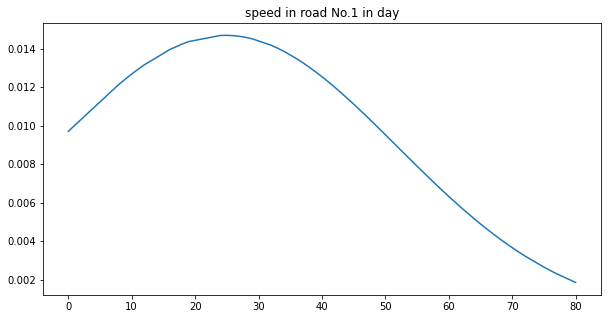

Mean = 24.72961373390558


In [57]:
import statistics
from scipy.stats import norm

x = sorted(list(tmp["speed"]))
mean = statistics.mean(x)
sd = statistics.stdev(x)
plt.figure(figsize=(10,5))
plt.title("speed in road No.1 in day")
plt.plot(x,norm.pdf(x,mean,sd))
plt.show()
print("Mean = " + str(mean))

In [58]:
def plot_sd_0(data,hour):
    timeat = data[data["time_range"] == hour]
    x_1 = sorted(list(timeat["speed"]))
    mean = statistics.mean(x_1)
    a = np.percentile(x_1,5)
    b = np.percentile(x_1,95)
    sd = statistics.stdev(x_1)
    print("Mean = {} percentile 5 = {} percentile 95 = {}".format(mean,a,b) )
    plt.figure(figsize=(10,5))
    plt.title("speed in road No.1 at {} am when not drop = 0".format(hour))
    plt.plot(x_1,norm.pdf(x_1,mean,sd))
    plt.show()


Mean = 8.5 percentile 5 = 0.0 percentile 95 = 38.25


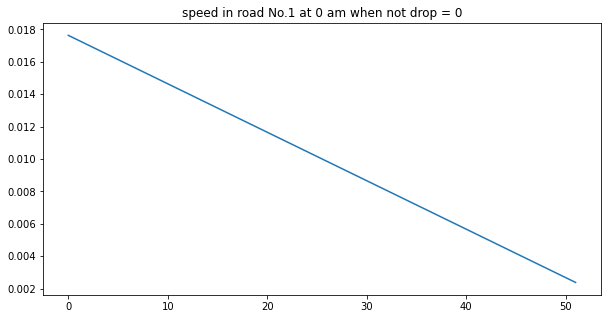

StatisticsError: variance requires at least two data points

In [59]:
for i in range(0,22):
    plot_sd_0(tmp,i)

In [33]:
timeat = tmp[tmp["time_range"] == 0]
x = sorted(list(timeat["speed"]))
x = [i for i in x if i >10]
mean = statistics.mean(x)
a = np.percentile(x,5)
b = np.percentile(x,95)
sd = statistics.stdev(x)
x_2 = [i for i in x if (i >= a and i <= b)]
mean2 = statistics.mean(x_2)
print(x)
print(x_2)
print("Mean = {} percentile 5 = {} percentile 95 = {} new Mean {}".format(mean,a,b,mean2) )


[20, 25, 26, 30, 34, 34, 35, 35, 40, 42, 43, 43, 43, 45, 45, 46, 47, 49, 49, 50, 51, 52, 52, 54, 54, 55, 57, 58, 59, 59, 60, 60, 62, 63, 64, 64, 65, 67, 68, 68, 68, 69, 69, 71, 72, 72, 74, 74, 76, 80, 81, 83, 84, 90, 91]
[30, 34, 34, 35, 35, 40, 42, 43, 43, 43, 45, 45, 46, 47, 49, 49, 50, 51, 52, 52, 54, 54, 55, 57, 58, 59, 59, 60, 60, 62, 63, 64, 64, 65, 67, 68, 68, 68, 69, 69, 71, 72, 72, 74, 74, 76, 80, 81, 83]
Mean = 56.85454545454545 percentile 5 = 28.8 percentile 95 = 83.3 new Mean 56.95918367346939


In [50]:
def plot_sd(data,hour):
    timeat = data[data["time_range"] == hour]
    x = sorted(list(timeat["speed"]))
    x_1 = [i for i in x if i > 10]
    mean = statistics.mean(x_1)
    a = np.percentile(x_1,5)
    b = np.percentile(x_1,95)
    sd = statistics.stdev(x_1)
    x_2 = [i for i in x_1 if (i >= a and i <= b)]
    mean2 = statistics.mean(x_2)
    print("Mean = {} percentile 5 = {} percentile 95 = {} new Mean {}".format(mean,a,b,mean2) )
    plt.figure(figsize=(10,5))
    plt.title("Velocity at {} am when drop 0".format(hour))
    plt.plot(x_1,norm.pdf(x_1,mean,sd))
    plt.show()


In [51]:
plot_sd(tmp,0)

KeyError: 'time_range'

In [45]:
for i in range(0,22):
    plot_sd(tmp,i)

StatisticsError: variance requires at least two data points